In [15]:
import gymnasium as gym
import torch
import numpy as np
import wandb
from collections import deque
from src.utils.util import ShellColor as sc

print(f"{sc.COLOR_PURPLE}Gym version:{sc.ENDC} {gym.__version__}")
print(f"{sc.COLOR_PURPLE}Pytorch version:{sc.ENDC} {torch.__version__}")

from src.agents.dqn_agent import DQNAgent
from src.utils import util as rl_util

Gym version: 0.27.0
Pytorch version: 1.12.0+cu113


In [16]:
env_name = "CartPole-v1"
env = gym.make(env_name)
rl_util.print_env_info(env=env)

============ Env Info ===========
Env id: CartPole-v1
Observation space size: (4,)
Action space size: 2


In [17]:
config = rl_util.create_config()
config["batch_size"] = 32
config["buffer_size"] = 20000
config["gamma"] = 0.99
config["learning_frequency"] = 4
config["target_update_frequency"] = 4
config["lr"] = 1e-4
config["replay_start_size"] = 1000
config["mean_reward_bound"] = 490
# config["buffer_type"] = "priority"
config["learning_starts"] = 1000

In [18]:
# wandb.init(project="DQN-PER-cartpole", config=config)

In [19]:
agent = DQNAgent(
    obs_space_shape=env.observation_space.shape,
    action_space_dims=env.action_space.n,
    is_atari=False,
    config=config,
    use_double_dqn=True
)

print(agent.config)
print(type(agent.memory))

Double DQN Agent
========== Config Info ==========
env: PongNoFrameskip-v4
num_steps: 1000000
batch_size: 32
gamma: 0.99
lr: 0.0001
learning_starts: 1000
learning_frequency: 4
epsilon_start: 1
epsilon_end: 0.01
epsilon_decay: 100000
seed: 0
target_update_frequency: 4
buffer_type: uniform
buffer_size: 20000
device: cuda:0
mean_reward_bound: 490
print_frequency: 10
<class 'src.commons.memory.replay_memory.ReplayMemory'>


In [20]:
save_dir = "result/DQN/per/"
rl_util.create_directory(save_dir)
save_model_name = save_dir + env_name + "_mean_score.pt"

In [21]:
state, _ = env.reset()
episode_rewards = [0.0]
best_mean_reward = -10000
for t in range(agent.config.num_steps):
    fraction = min(1.0, float(t) / agent.config.epsilon_decay)
    eps_threshold = agent.config.epsilon_start + fraction * \
        (agent.config.epsilon_end - agent.config.epsilon_start)
    # sample = random.random()
    action = agent.select_action(state, eps_threshold)
    next_state, reward, done, _, info = env.step(action)
    agent.store_transition(state, action, reward, next_state, float(done))
    state = next_state

    episode_rewards[-1] += reward
    if done:
        state, _ = env.reset()
        episode_rewards.append(0.0)

    if t > agent.config.learning_starts and t % agent.config.learning_frequency == 0:
        agent.update()

    if t > agent.config.learning_starts and t % agent.config.target_update_frequency == 0:
        agent.update_target_network()

    num_episodes = len(episode_rewards)

    if done and agent.config.print_frequency is not None and len(episode_rewards) % agent.config.print_frequency == 0:
        mean_100ep_reward = round(np.mean(episode_rewards[-101:-1]), 1)
        print("********************************************************")
        print("steps: {}".format(t))
        print("episodes: {}".format(num_episodes))
        print("mean 100 episode reward: {}".format(mean_100ep_reward))
        print("% time spent exploring: {}".format(int(100 * eps_threshold)))
        print("********************************************************")
        # wandb.log({
        #     "episode": num_episodes,
        #     "mean reward": mean_100ep_reward,
        #     "epsilon": eps_threshold
        # })
        if best_mean_reward < mean_100ep_reward:
            torch.save(agent.policy_network.state_dict(), save_model_name)
            print(f"Best mean reward updated {best_mean_reward:.3f} -> {mean_100ep_reward:.3f}, model saved")
            best_mean_reward = mean_100ep_reward
            if mean_100ep_reward > agent.config.mean_reward_bound:
                print(f"Solved!")
                break
            # else:
            #     if num_episodes > 1000:
            #         break

********************************************************
steps: 160
episodes: 10
mean 100 episode reward: 17.9
% time spent exploring: 99
********************************************************
Best mean reward updated -10000.000 -> 17.900, model saved
********************************************************
steps: 420
episodes: 20
mean 100 episode reward: 22.2
% time spent exploring: 99
********************************************************
Best mean reward updated 17.900 -> 22.200, model saved
********************************************************
steps: 658
episodes: 30
mean 100 episode reward: 22.7
% time spent exploring: 99
********************************************************
Best mean reward updated 22.200 -> 22.700, model saved
********************************************************
steps: 873
episodes: 40
mean 100 episode reward: 22.4
% time spent exploring: 99
********************************************************
***************************************************

Save result/DQN/per/reward_2023_02_12_06_44_41.png


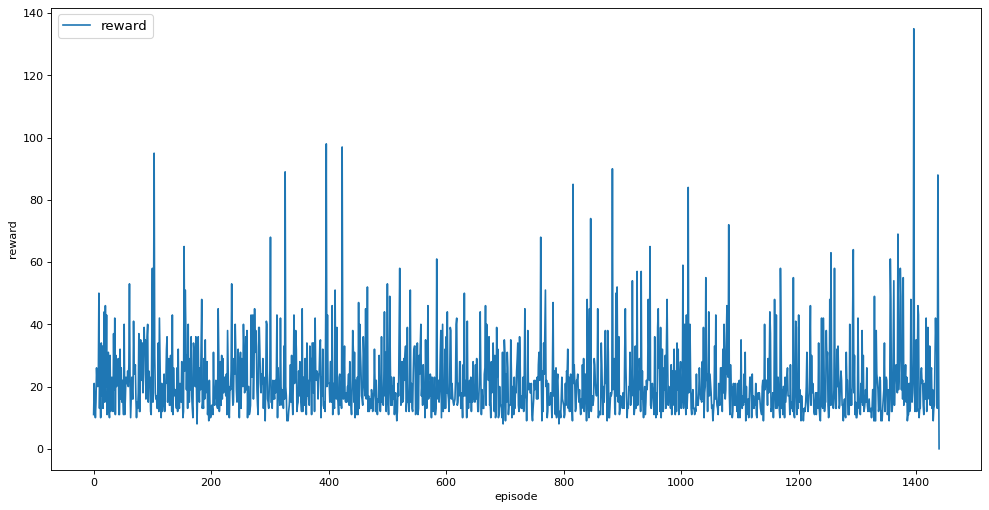

In [22]:
fig, ax = rl_util.init_2d_figure("Reward")
rl_util.plot_graph(
    ax,
    episode_rewards,
    title="reward",
    ylabel="reward",
    save_dir_name=save_dir,
    is_save=True,
)
rl_util.show_figure()
# fig, ax = rl_util.init_2d_figure("Loss")
# rl_util.plot_graph(
#     ax, losses, title="loss", ylabel="loss", save_dir_name=save_dir, is_save=True
# )
# rl_util.show_figure()

In [23]:
env = gym.make(env_name, render_mode="human")

test_agent = DQNAgent(
    obs_space_shape=env.observation_space.shape,
    action_space_dims=env.action_space.n,
    is_atari=False,
)

# file_name = save_dir + "CartPole-v1_mean_score.pt"
test_agent.policy_network.load_state_dict(torch.load(save_model_name))

for i_episode in range(1):
    state, _ = env.reset()
    test_reward = 0
    while True:
        env.render()
        action = test_agent.select_action(state, 0.)
        next_state, reward, terminated, truncated, _ = env.step(action)
        test_reward += reward
        state = next_state
        done = terminated or truncated
        if done:
            break
    print(f"{i_episode} episode Total Reward: {test_reward}")
env.close()

KeyError: 'seed'